In [1]:
#reproducible
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv1D, MaxPooling1D, Embedding, GlobalAveragePooling1D
import tensorflow as tf
import tensorflow.keras.optimizers
from numpy import concatenate
from matplotlib import pyplot
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
import random
import numpy as np

In [2]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
cvscores = []
for i in range (1):
    tf.compat.v1.get_default_graph()
    tf.random.set_seed(2)
    random.seed(2)
    np.random.seed(2)
    df= read_csv('*/EasternFiles.csv', header=0, index_col=0)

    values=df.values
    values = values.astype('float32')

    # specify the number of lag hours
    n_hours = 5
    n_features = 9

    # frame as supervised learning
    reframed = series_to_supervised(values, n_hours, 1)

    # split into train and test sets
    values = reframed.values

    #Split into train and test set
    n_train_hours = int(values.shape[0]*0.7)
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]

    # split into input and outputs
    n_obs = n_hours * n_features
    train_X, train_y = train[:, :n_obs], train[:, -n_features]
    test_X, test_y = test[:, :n_obs], test[:, -n_features]

    #Scale Xinputes and outputs
    x_scaler = MinMaxScaler()
    train_X = x_scaler.fit_transform(train_X)
    test_X = x_scaler.transform(test_X)

    #reshape output
    test_y = test_y.reshape((len(test_y), 1))
    train_y = train_y.reshape((len(train_y), 1))
    n_outputs =train_y.shape[1]

    #Scale Yinputes and outputs
    y_scaler = MinMaxScaler()
    train_y = y_scaler.fit_transform(train_y)
    test_y = y_scaler.transform(test_y)

    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
    test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

    model = Sequential()
    #model.add(Conv1D(filters=32, kernel_size=1, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=18, kernel_size=1, activation='relu',input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(MaxPooling1D(pool_size=1))
    
    model.add(Conv1D(filters=6, kernel_size=1, activation='relu'))
    model.add(MaxPooling1D(pool_size=1))
    
    model.add(Conv1D(filters=6, kernel_size=1, activation='relu'))
    model.add(MaxPooling1D(pool_size=1))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    
    #print(model.summary())
    # fit network
    history = model.fit(train_X, train_y, epochs=50, batch_size=64, validation_data=(test_X, test_y), verbose=1, shuffle=False)

    # make a prediction
    yhat = model.predict(test_X)

    #inverse the scales
    yhat = y_scaler.inverse_transform(yhat)
    inv_y = y_scaler.inverse_transform(test_y)

    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, yhat))
    print('Test RMSE: %.3f' % rmse)

    cvscores.append(rmse)
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
print(cvscores)

Train on 2628 samples, validate on 1127 samples
Epoch 1/50
2628/2628 [==============================] - 1s 290us/sample - loss: 0.0070 - val_loss: 0.0148
Epoch 2/50
2628/2628 [==============================] - 0s 56us/sample - loss: 0.0096 - val_loss: 0.0120
Epoch 3/50
2628/2628 [==============================] - 0s 55us/sample - loss: 0.0098 - val_loss: 0.0112
Epoch 4/50
2628/2628 [==============================] - 0s 48us/sample - loss: 0.0098 - val_loss: 0.0102
Epoch 5/50
2628/2628 [==============================] - 0s 50us/sample - loss: 0.0101 - val_loss: 0.0098
Epoch 6/50
2628/2628 [==============================] - ETA: 0s - loss: 0.019 - ETA: 0s - loss: 0.008 - 0s 48us/sample - loss: 0.0096 - val_loss: 0.0092
Epoch 7/50
2628/2628 [==============================] - 0s 50us/sample - loss: 0.0095 - val_loss: 0.0091
Epoch 8/50
2628/2628 [==============================] - 0s 54us/sample - loss: 0.0083 - val_loss: 0.0088
Epoch 9/50
2628/2628 [==============================] - 0s 47us

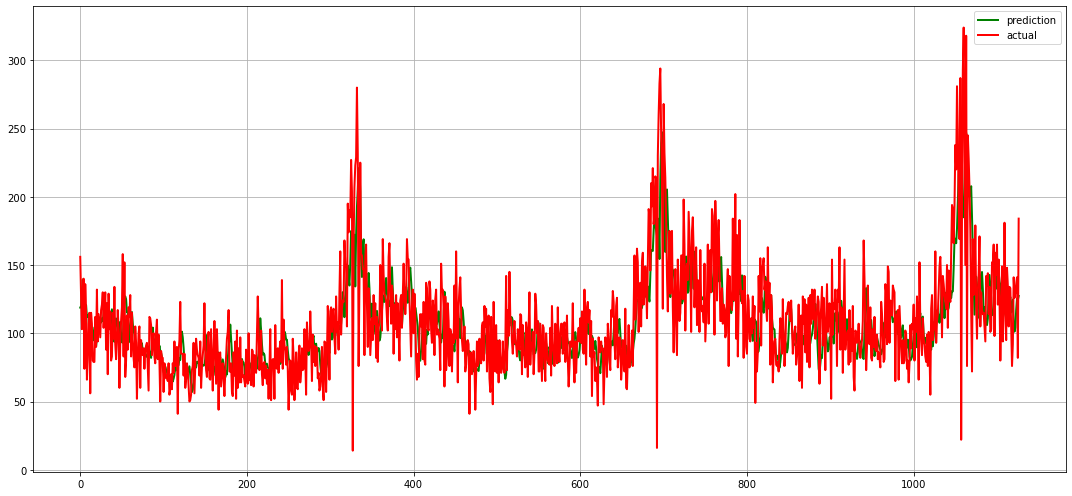

In [4]:
import matplotlib.pyplot as plt

plot_anomalies=False
plt.figure(figsize=(15, 7))
   
x = range(inv_y.size)
plt.plot(x, yhat, label='prediction', color='green', linewidth=2.0)
plt.plot(x, inv_y, label='actual',color='red', linewidth=2.0)
   
plt.legend(loc='best')
plt.tight_layout()
plt.grid(True)